# Milestone Project 3 - BitPredict (Time Series Forecasting Sequence Models)

For this project, I am going to dive into analyzing time series fundamentals through building out various models that will be used to predict the price of bitcoin for the next day. This will ultimately show how even deep learning models can have models.

The data I will be looking at will consist of the historical prices of Bitcoin. This data is part of the TensorFlow certification course master github repository, located at the raw data file linked below.

* https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb
* https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

This problem represents a many-to-one sequence problem. The reason for this is because it uses historical data to only predict the following day, rather than predicting multiple following days. For our models, I will only be looking at the closing price of bitcoin at the end of each day.

#### Time Series Evaluation Metrics

Let's look into some eavluation metrics for time series forecasting. The purpose of this model is to predict a number, so this is a regression type problem. Because we are workin on a regression problem, we'll need some regression like metrics.

A few common regression metrics which can be used for time series forecasting:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is betteR**. For example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is: How do our model's forecasts y_pred) compare against the actual values (y_true)?

## Environment Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
if on_colab:
  # Setting up the notebook with a GPU
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .
  !rm -rf ./notebooks

## Imports

Importing all the libraries required to run all code blocks in this notebook.

In [3]:
import datetime as dt
import random
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
import scipy
from sklearn.preprocessing import minmax_scale
import tensorflow as tf
import tensorflow_hub as hub

## Global Constants

Constants that are standard/used for the corresponding experiments.

## Helpers

Helper functions used throughout this notebook.

In [4]:
def plot_timeseries(timesteps: np.ndarray[np.datetime64],
                    values: typing.Union[np.ndarray, tf.Tensor, list],
                    format: str = '.',
                    start: int = 0,
                    end: typing.Optional[int] = None,
                    label: typing.Optional[str] = None,
                    title: typing.Optional[str] = None,
                    new_figure: bool = False) -> None:
    """ Plots the timeseries data.

        Args:
            timesteps (np.ndarray[np.datetime64]): the timesteps associated with the timeseries
                data to be plotted on the x-axis.
            values (typing.Union[np.ndarray, tf.Tensor, list]): the pricing data for the timeseries
                to be plotted on the y-axis.
            format (str): the type of format to use for the plot ('.', '-', 'g', etc...)
            start (int): the starting point of the plot (used to "zoom in" the plot)
            end (int): the end point of the plot (used to "zoom in" the plot)
            label (str): label of the plot (used in legend).
            title (str): title the plot.
            new_figure (bool): whether or not to generate a new figure when called.
    """
    if new_figure:
        plt.figure(figsize=(10, 7))

    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC Price ($)')

    if title:
        plt.title(title)

    if label:
        plt.legend(fontsize=14);

    plt.grid(True)

In [5]:
def get_labeled_windows(x, horizon: int = 1) -> typing.Tuple[typing.List, typing.List]:
    """ Create labels for windowed dataset.

        E.g. if horizon=1
            Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])

        Args:
            x (ArrayLike): the data to generate the window and horizon for.
            horizon (int): the size of the output length list.

        Returns:
            (typing.Tuple) the separated window and horizon of the data.
    """
    return x[:, :-horizon], x[:, -horizon:]

In [6]:
def make_windows(x, window_size: int = 7, horizon: int = 1):
    """ Turns a 1D array into a 2D array of sequential labeled windows of
        window_size with horizon size labels.

        Args:
            x (ArrayLike): the data to make windows from.
            window_size (int): the size of the window.
            horizon (int): the size of the horizon.

        Returns:
            (typing.Tuple) 2D array of labeled windowed dataset.
    """
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # create 2D array of windows of size, window_size
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

    windowed_array = x[window_indexes]

    # Get labeled windows
    return get_labeled_windows(windowed_array, horizon=horizon)

In [7]:
def make_train_test_split(data, labels, test_split: float = 0.2) -> typing.Tuple:
    """ Splits matching pairs of data and labels into train and test splits.

        Args:
            data (ArrayLike): the data to split.
            labels (ArrayLike): the labels corresponding to the windowed data
            test_split (float): the fraction of data dedicated to be used as test set,
                must fall between 0-1.

        Raises:
            AssertionError: when test_split does not fall between 0-1.

        Returns
            (typing.Tuple) the train-test split of the windows and labels
                -> (X_train, X_test, y_train, y_test).
    """
    assert (test_split >= 0 and test_split <= 1), 'test_split must be between 0-1'

    split_index = int(len(data) * (1 - test_split))

    X_train = data[:split_index]
    y_train = labels[:split_index]
    X_test = data[split_index:]
    y_test = labels[split_index:]

    return X_train, X_test, y_train, y_test

In [8]:
def make_predictions(model: tf.keras.models.Model, input_data: tf.Tensor) -> tf.Tensor:
    """ Uses model to make predictions on input data.

        Args:
            model (Model): the model to use when making predictions.
            input_data (ArrayLike): the data to predict on.

        Returns:
            (Tensor): the predictions
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [9]:
def map_block_reward_to_date(row: pd.Series) -> float:
    """ Helper function that maps a timeseries date to the corresponding block reward value.

        Note: for this helper to work, the row.name must be the datetime of the given price.

        The values and datetimes come from the following link
        - https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

        Args:
            row (pd.Series): The corresponding dataframe row to check the date against.

        Returns:
            (float): The correspponding block reward for the given date.
    """
    if row.name < np.datetime64("2012-11-28"):
        return 50.
    elif row.name < np.datetime64("2016-07-09"):
        return 25.
    elif row.name < np.datetime64("2020-05-11"):
        return 12.5
    else:
        return 6.25

In [10]:
def get_ensemble_models(horizon: int,
                        window_size: int,
                        train_data: tf.data.Dataset,
                        test_data: tf.data.Dataset,
                        num_iter: int = 10,
                        num_epochs: int = 100,
                        loss_fns: typing.Optional[typing.List[str]] = None) -> typing.List[tf.keras.models.Sequential]:
    """ Returns a list of num_iter models each trained on loss function metrics.

        Example:
            num_iter=10 and loss_fn=['mae', 'mse', 'mape'],  a list of 30 trained models
            will be returned: 10 * len(['mae', 'mse', 'mape'])

        Args:
            horizon (int): the horizon for each model.
            window_size (int): the size of the window (input size).
            train_data (tf.data.Dataset): the dataset to train the models on.
            test_data (tf.data.Dataset): the dataset to test/validate the models on.
            num_iter (int): the number of models for each loss function metric.
            num_epochs (int): the number of epochs to train the model on.
            loss_fns (List[str]): the loss function metrics to fit the model with.
                Defaults to ['mae', 'mse', 'mape'].

        Returns:
            (List[Model]) the list of trained models.
    """
    if loss_fns is None:
        loss_fns = ['mae', 'mse', 'mape']

    ensemble_models = []

    for i in range(num_iter):
        for loss_fn in loss_fns:
            print(f'Optimizing model by reducing: {loss_fn} for {num_epochs}, model number: {i}')

            # Build Model
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(window_size,)),
                tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(horizon),
            ], name=f'ensemble_model_{loss_fn}_{i}')

            # Compile Model
            model.compile(loss=loss_fn,
                          optimizer=tf.keras.optimizers.legacy.Adam(),
                          metrics=['mae', 'mse'])

            # Fit Model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=200,
                                                                  restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                      patience=100,
                                                                      verbose=1)])

            ensemble_models.append(model)

    return ensemble_models

In [11]:
def make_ensemble_preds(ensemble_models: typing.List[tf.keras.models.Model],
                        data_to_predict: tf.data.Dataset) -> tf.Tensor:
    """ Generates predictions on a list of models, and transforms the predictions into a tf.Tensor.

        Args:
            ensemble_models (List[tf.keras.models.Model]): the list of models to run predictions with.
            data_to_predict (tf.data.Dataset): the data to run predictions on.

        Returns:
            (tf.Tensor): the predictions from each model on the corresponding dataset.
    """
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data_to_predict)
        ensemble_preds.append(preds)

    return tf.constant(tf.squeeze(ensemble_preds))

In [12]:
# Find upper and lower bounds of predictions
def get_upper_lower(predictions: tf.Tensor, percentile: float = 0.95) -> typing.Tuple[tf.Tensor, tf.Tensor]:
    """ Generates the prediction upper and lower bounds based of the designated confidence percentile.

        Args:
            predictions (tf.Tensor): the predictions to generate confidence range on.
            percentile (float): the percentile level of confidence to create a range from.

        Returns:
            (typing.Tuple[tf.Tensor, tf.Tensor]) the lower and upper bounds for each prediction.
    """
    std_dev = tf.math.reduce_std(predictions, axis=0)
    preds_mean = tf.reduce_mean(predictions, axis=0)

    # 1.96 is the num of standard deviations from mean to be within the 95% confidence interval
    interval = scipy.stats.norm.ppf(1-(1-percentile)/2) * std_dev

    lower = preds_mean - interval
    upper = preds_mean + interval

    return lower, upper

In [13]:
def make_future_forecasts(values: tf.data.Dataset,
                          model: tf.keras.models.Model,
                          into_future: int,
                          window_size: int,
                          log_step: bool = False) -> typing.List[float]:
    """ Make future forecasts for a set number of steps.

        Args:
            values (tf.data.Dataset): the values to make forecasts on.
            model (tf.keras.models.Model): the model to make the predictions with.
            into_future (int): how far into the future to make predictions.
            window_size (int): how big of a window to use when making forecasts.
            log_step (bool): whether or not to log the step in the process.

        Returns:
            (typing.List[float]) the future forecasts.
    """
    future_forecast = []
    last_window = values[-window_size:]

    for _ in range(into_future):
        # Making forcasts on own forecast
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)
        pred = tf.squeeze(future_pred).numpy()

        if log_step:
            print(f'Predicting On: \n {last_window} -> Prediction: {pred}')

        future_forecast.append(pred)

        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [14]:
def get_future_dates(start_date: np.datetime64, into_future: int = 7, offset: int = 1) -> np.ndarray[np.datetime64]:
    """ Generates the following dates from the start date for a number of days into the future.

        Example:
            get_future_dates('7/12/2022', 3, 3) -> ['7/15/2022', '7/16/2022', '7/17/2022']

        Args:
            start_date (np.datetime64): the starting date used to determine the future dates from.
            into_future (int): the number of days into the future to generate dates for.
            offset (int): how far to offset into the future from the start_date to start
                the future dates generation.

        Returns:
            (np.ndarray[np.datetime64]) the future dates offset from the starting date.
    """
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_future, 'D')

    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [15]:
# Global Constants/Hyper Parameters
RANDOM_SEED = 42

BATCH_SIZE = 128
BATCH_SIZE_LARGE = 1024
EPOCHS = 100

WINDOW_SIZE_30 = 30
WINDOW_SIZE_7 = 7
HORIZON_1 = 1
HORIZON_7 = 7

## Data Download, Analysis, and Processing

### Downloading & Analyzing Data

There are multiple ways to read in data. The first step should identify where to get the data, and what the file format the data is already in. In this case, the data is a `csv` file directly from a url link. Pandas offers a quick and easy way to read in csv files into a dataframe. The alternative method is to use python file reading directly (not implemented in this notebook).

In [16]:
# Raw Data URL
data_url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

In [17]:
raw_df = pd.read_csv(data_url, parse_dates=['Date'], index_col=['Date'])
raw_df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [19]:
# Looking at the number of samples we have
len(raw_df)

2787

##### Findings

This dataset only has 2787 samples over ~8 years. Typically, deep learning models perform better when there is a significant amount of data (thousands, tens of thousands, millions, etc...).

**NOTE** A smaller number of samples is something that is commonly ran into when working with time series data problems. The reason for this is due to the time data typicaly only being registered with a daily value (365 samples are added in a single year).

### Creating Datasets

For this problem, I don't care about the high, low, or open prices. The only data I am going to use is the closing price for the day.

In [20]:
# Looking at only Closing price
bitcoin_prices = pd.DataFrame(raw_df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})

# Converting to arrays
prices = bitcoin_prices['Price'].to_numpy()
timesteps = bitcoin_prices.index.to_numpy()

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


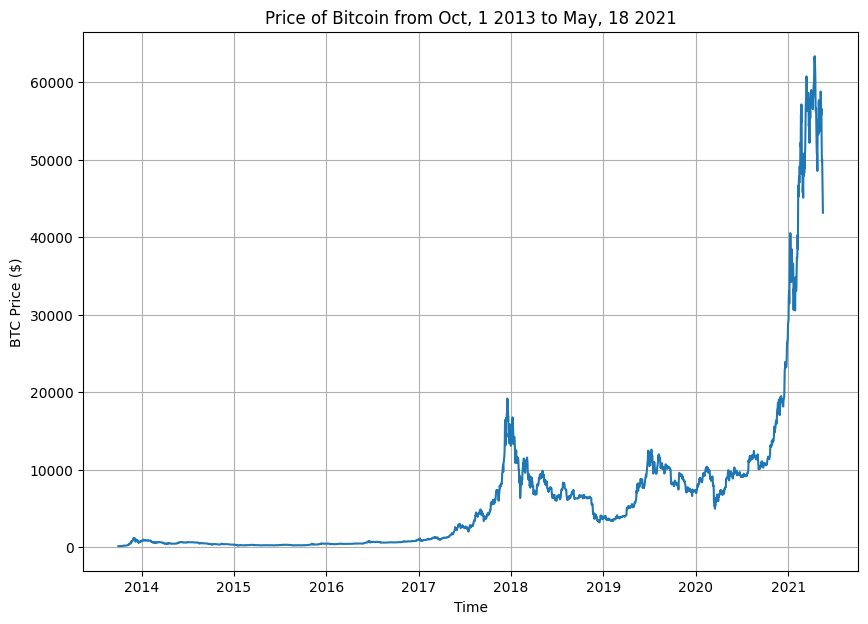

In [21]:
plot_timeseries(timesteps,
                prices,
                format='-',
                title='Price of Bitcoin from Oct, 1 2013 to May, 18 2021',
                new_figure=True)

### Creating Train & Test Data

The first thought of splitting data into train and test sets, it might be easy to think of using `sklearn.model_selection.train_test_split`, however, this would be wrong for sequence data. The reason for this is doing the train test loses the 'time' aspect of the data.

The whole purpose of the models is to predict the following day's BTC price, based off HISTORICAL data, without knowledge of FUTURE data! The train test split randomly grabs data from all dates in the complete dataset to train the data. The problem with this is that now when testing the model, test points would fall anywhere in the timeline, which the model would have been trained around with knowledge of how the data will change on following days. In short, doing it this way skews the accuracy of the model because it is like the model was able to look into the future to know what the value would be in days following the day you are trying to predict.

In [22]:
# Create train and test splits
timestamp_train, timestamp_test, price_train, price_test = make_train_test_split(timesteps, prices)

len(timestamp_train), len(price_train), len(timestamp_test), len(price_test)

(2229, 2229, 558, 558)

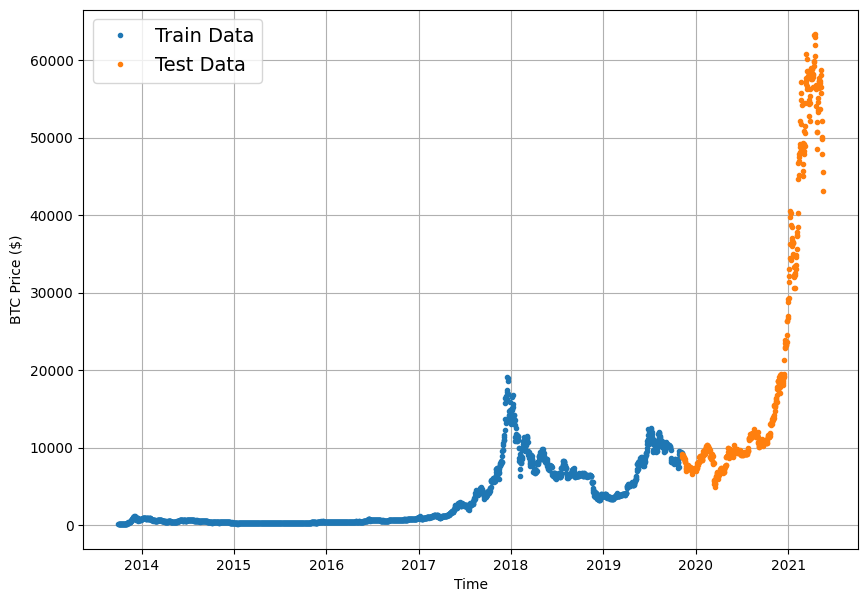

In [23]:
# Plot Splits
plt.figure(figsize=(10, 7))
plot_timeseries(timestamp_train, price_train, label='Train Data', new_figure=False)
plot_timeseries(timestamp_test, price_test, label='Test Data', new_figure=False)

### Windowing Dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

**NOTE**: You can find a function which achieves similar results to the ones we implemented above at `tf.keras.preprocessing.timeseries_dataset_from_array()`. Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

#### Standard Windowed Datasets

Experiments 1-5 use historical pricing only to make predictions.

The datasets need for the experiments will require different windows and horizons for the test and training data. The following datasets will be generated:

* (`full_windows_w7_h1` `full_labels_w7_h1`): full dataset and corresponding lables for a `window_size=7` with a `horizon=1`.
* (`full_windows_w30_h1` `full_labels_w30_h1`): full dataset and corresponding lables for a `window_size=30` with a `horizon=1`.
* (`full_windows_w30_h7` `full_labels_w30_h7`): full dataset and corresponding lables for a `window_size=30` with a `horizon=7`.

In [24]:
# Splitting Data for full_windows_w7_h1 full_labels_w7_h1
full_windows_w7_h1, full_labels_w7_h1 = make_windows(prices, window_size=7, horizon=1)
train_windows_w7_h1, test_windows_w7_h1, train_labels_w7_h1, test_labels_w7_h1 = make_train_test_split(full_windows_w7_h1,
                                                                                                       full_labels_w7_h1)

len(train_windows_w7_h1), len(test_windows_w7_h1), len(train_labels_w7_h1), len(test_labels_w7_h1)

(2224, 556, 2224, 556)

In [25]:
# Splitting Data for full_windows_w30_h1 full_labels_w30_h1
full_windows_w30_h1, full_labels_w30_h1 = make_windows(prices, window_size=30, horizon=1)
train_windows_w30_h1, test_windows_w30_h1, train_labels_w30_h1, test_labels_w30_h1 = make_train_test_split(full_windows_w30_h1,
                                                                                                           full_labels_w30_h1)

len(train_windows_w30_h1), len(test_windows_w30_h1), len(train_labels_w30_h1), len(test_labels_w30_h1)

(2205, 552, 2205, 552)

In [26]:
# Splitting Data for full_windows_w30_h1 full_labels_w30_h7
full_windows_w30_h7, full_labels_w30_h7 = make_windows(prices, window_size=30, horizon=7)
train_windows_w30_h7, test_windows_w30_h7, train_labels_w30_h7, test_labels_w30_h7 = make_train_test_split(full_windows_w30_h7,
                                                                                                           full_labels_w30_h7)

len(train_windows_w30_h7), len(test_windows_w30_h7), len(train_labels_w30_h7), len(test_labels_w30_h7)

(2200, 551, 2200, 551)

#### Multivariate Windowed Datasets

Experiment-6 looks into adding an additional data point for each window, providing new information to help make predictions.
* (`full_windows_mv` `full_labels_mv`): full dataset and corresponding lables for a `window_size=7` with a `horizon=1`, and includes `block_reward`.

The current windowing function does not support multivariate data, so I will have to window this dataset directly. To do this, I want it to behave as the following:

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

I will do this by working directly with the pandas df.

In [27]:
# Create column with the block reward for the given day
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = bitcoin_prices_block.apply(map_block_reward_to_date, axis=1)

bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25.00
2013-10-02,125.455000,25.00
2013-10-03,108.584830,25.00
2013-10-04,118.674660,25.00
2013-10-05,121.338660,25.00
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


In [28]:
# Verify Data is Correct
bitcoin_prices_block['block_reward'].value_counts()

block_reward
12.50    1402
25.00    1012
6.25      373
Name: count, dtype: int64

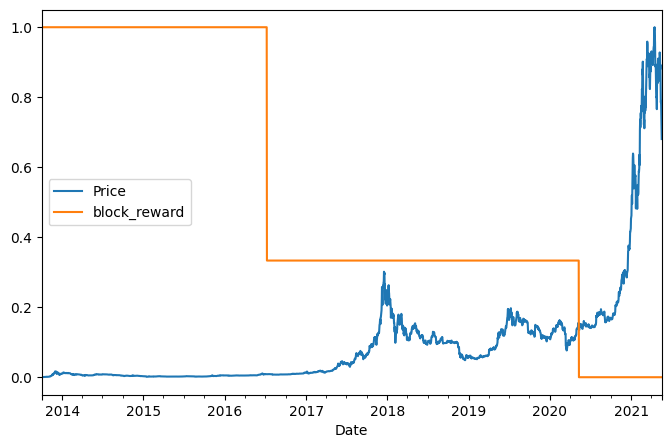

In [29]:
# Plot Block reward vs price over time to Verify any Corelation
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(8,5));

In [30]:
# Make Windowed Dataset
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE_7):
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [31]:
# Create X (windows) and y (horizons)
full_windows_mv = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
full_labels_mv = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

full_windows_mv.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [32]:
# Create train/test Sets
split_size = int(len(full_windows_mv) * 0.8)

train_windows_mv, train_labels_mv = full_windows_mv[:split_size].to_numpy(), full_labels_mv[:split_size].to_numpy()
test_windows_mv, test_labels_mv = full_windows_mv[split_size:].to_numpy(), full_labels_mv[split_size:].to_numpy()

len(train_windows_mv), len(train_labels_mv), len(test_windows_mv), len(test_labels_mv)

(2224, 2224, 556, 556)

#### Large Batch Datasets

Experiments 7-8 use a larger Batch for the dataset due to the size of the model. The models in Experiments 7-8 use `window_size=7` and a `horizon=1`.

In [33]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE_7):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

# Make features and labels
X_large_batch = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y_large_batch = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X_large_batch) * 0.8)
X_train_large_batch, y_train_large_batch = X_large_batch[:split_size], y_large_batch[:split_size]
X_test_large_batch, y_test_large_batch = X_large_batch[split_size:], y_large_batch[split_size:]

train_dataset_large_batch = data_toolbox.generate_dataset_from_data([X_train_large_batch],
                                                                    y_train_large_batch,
                                                                    batch_size=BATCH_SIZE_LARGE)

test_dataset_large_batch = data_toolbox.generate_dataset_from_data([X_test_large_batch],
                                                                   y_test_large_batch,
                                                                   batch_size=BATCH_SIZE_LARGE)

train_dataset_large_batch, test_dataset_large_batch

2023-09-10 15:47:14.588912: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-10 15:47:14.588933: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-10 15:47:14.588938: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-10 15:47:14.588969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-10 15:47:14.588983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#### Complete Dataset (Future Predictions)

Experiment-9 analyzes future predictions, and uses it's predictions to generate future predictions. To do this, I need a dataset the encompasses the entire historical pricing data.

In [34]:
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [35]:
features_dataset_all = data_toolbox.generate_dataset_from_data([X_all], y_all, batch_size=BATCH_SIZE_LARGE)
features_dataset_all

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

#### Turkey Dataset

Experiment-10 analyzes the "Turkey Problem", by introducing a single point that reduces the bitcoin price by 100x that day. The purpose of this is to show how a single data point can completely break a model.

To analyze this issue, I am going to create a dataset that has the last price in the test dataset be 100x lower than the actual price. This will simulate Bitcoin crashing that day and loseing 100x it's value.

In [36]:
# Creating detrimental data
prices_turkey = prices.copy()

# Change that the last day, the BTC price dropped 100X
prices_turkey[-1] = prices_turkey[-1] / 100
btc_timesteps_turkey = bitcoin_prices.index.to_numpy()

prices_turkey[-10:], btc_timesteps_turkey[-10:]

(array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361,   431.44471291]),
 array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
        '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
        '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
        '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
        '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
       dtype='datetime64[ns]'))

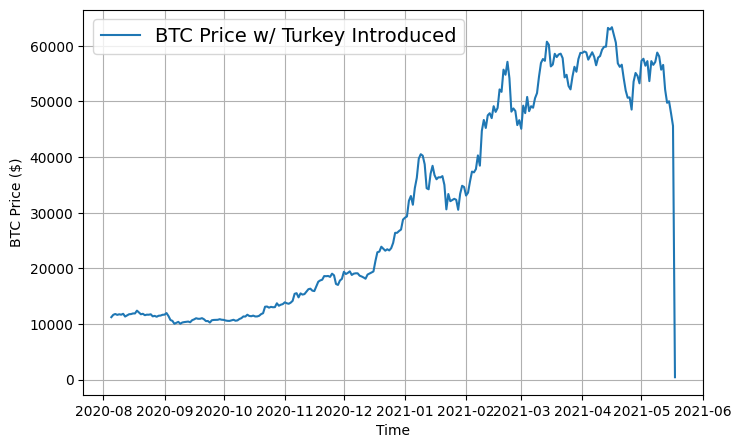

In [37]:
# Visualizing the Turkey Data
plt.figure(figsize=(8, 5))
plot_timeseries(timesteps=btc_timesteps_turkey,
                values=prices_turkey,
                start=2500,
                format='-',
                label='BTC Price w/ Turkey Introduced',
                new_figure=False)

In [38]:
# Split Data
full_turkey_windows, full_turkey_labels = make_windows(np.array(prices_turkey), window_size=WINDOW_SIZE_7, horizon=HORIZON_1)

X_train_turkey, X_test_turkey, y_train_turkey, y_test_turkey = make_train_test_split(full_turkey_windows, full_turkey_labels)

print(len(X_train_turkey), len(X_test_turkey), len(y_train_turkey), len(y_test_turkey))

2224 556 2224 556


## Experiments
Now that I have historical bitcoin pricing data, I am going to run a handful of experiments.

Terms to be familiar with:
* **Horizon** - Number of timesteps into the future we're going to predict.
* **Window Size** - Number of timesteps we're going to use to predict horizon.

The model experiments are listed below:
* Model-0 (baseline): Naive Forecast
* Model-1: Dense Model (Horizon=1, Window=7)
* Model-2: Dense Model (Horizon=1, Window=30)
* Model-3: Dense Model (Horizon=7, Window=30)
* Model-4: Conv1D
* Model-5: LSTM
* Model-6: Dense with multivariate data
* Model-7: N-BEATS Algorithm
* Model-8: Ensemble (Multiple Models Stacked together)
* Model-9: Future Prediction Model
* Model-10: Dense with turkey data introduced

### Model-0 (Baseline): Naive Model

The Naive approach uses the following formula:

$$\hat{y}_{t} = t_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [39]:
# Constants
model_0_name = 'model_0_naive'

In [40]:
# Data Setup
# Offset forecast by Horizon of 1
naive_forecast = price_test[:-1]
naive_forecast[-5:], price_test[-5:]

(array([52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361]),
 array([49764.1320816 , 50032.69313676, 47885.62525472, 45604.61575361,
        43144.47129086]))

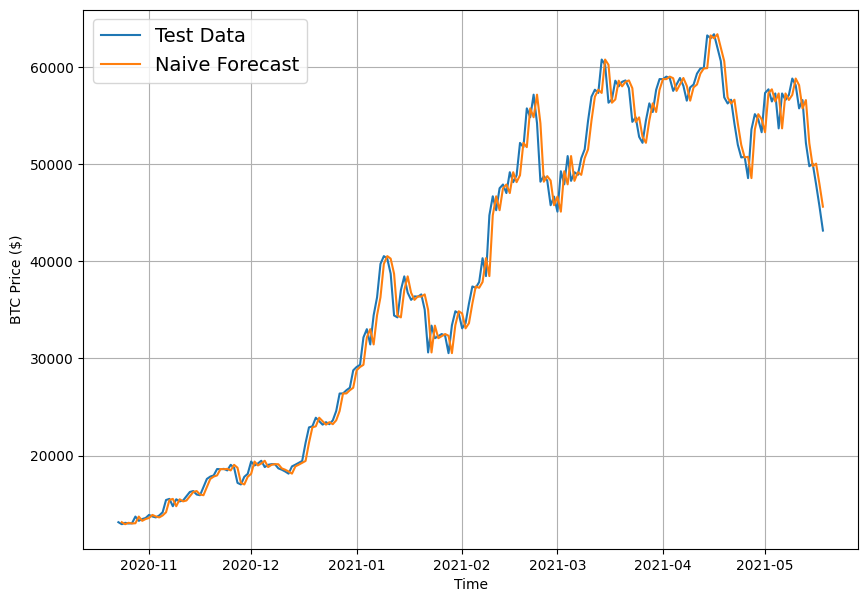

In [41]:
# Data Visualization
plt.figure(figsize=(10,7))
plot_timeseries(timestamp_test, price_test, format='-', start=350, label='Test Data', new_figure=False)
plot_timeseries(timestamp_test[1:], naive_forecast, format='-', start=350, label='Naive Forecast', new_figure=False)

In [42]:
# Predictions
model_0_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_true=price_test[1:],
                                                                             y_pred=naive_forecast,
                                                                             name=model_0_name)
model_0_results

RegressionPredictionMetrics(mae=567.9802273457542, mse=1147547.125023896, rmse=1071.2362601330744, mape=2.516524929982267, mase=0.9995699939182626, huber=567.4802, name='model_0_naive')

### Model-1: Dense Model (Horizon=1, Window=7)

This model will be a simple Dense model with the following parameters

* Single Dense layer with 128 hidden units and ReLU
* Output Layer with linear activation (no activation)
* Adam Optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [43]:
# Constants
model_1_name = 'model_1_dense_w7_h1'

In [44]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE_7,), name='input'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON_1, activation='linear')
], name=model_1_name)

model_1.summary()

Model: "model_1_dense_w7_h1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Compile Model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [46]:
# Fit Model
model_1_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_1_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_1_history = model_1.fit(train_windows_w7_h1,
                              train_labels_w7_h1,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_w7_h1, test_labels_w7_h1),
                              callbacks=[model_1_best_weights_checkpoint])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 1503.2700 - mae: 1503.2700 - mse: 7064914.0000 

2023-09-10 15:47:15.212562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1129.0790 - mae: 1129.0790 - mse: 4758974.0000
Epoch 1: val_loss improved from inf to 3354.68896, saving model to checkpoints/model_1_dense_w7_h1/20230910-154715/checkpoint.ckpt
18/18 [==============================] - 1s 16ms/step - loss: 1129.0790 - mae: 1129.0790 - mse: 4758974.0000 - val_loss: 3354.6890 - val_mae: 3354.6890 - val_mse: 24888618.0000
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 337.0120 - mae: 337.0120 - mse: 505320.5312 

2023-09-10 15:47:15.526514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 3354.68896 to 1185.13110, saving model to checkpoints/model_1_dense_w7_h1/20230910-154715/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 306.3919 - mae: 306.3919 - mse: 418451.7188 - val_loss: 1185.1311 - val_mae: 1185.1311 - val_mse: 4625733.0000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 214.7133 - mae: 214.7133 - mse: 213193.6562
Epoch 3: val_loss improved from 1185.13110 to 1067.24194, saving model to checkpoints/model_1_dense_w7_h1/20230910-154715/checkpoint.ckpt
18/18 [==============================] - 0s 10ms/step - loss: 214.7133 - mae: 214.7133 - mse: 213193.6562 - val_loss: 1067.2419 - val_mae: 1067.2419 - val_mse: 3798695.5000
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 213.2840 - mae: 213.2840 - mse: 239909.8750
Epoch 4: val_loss improved from 1067.24194 to 1035.56897, saving model to checkpoints/model_1_dense_w7_h1/20230910-154715/checkpoint.ckpt
18/18 [=======

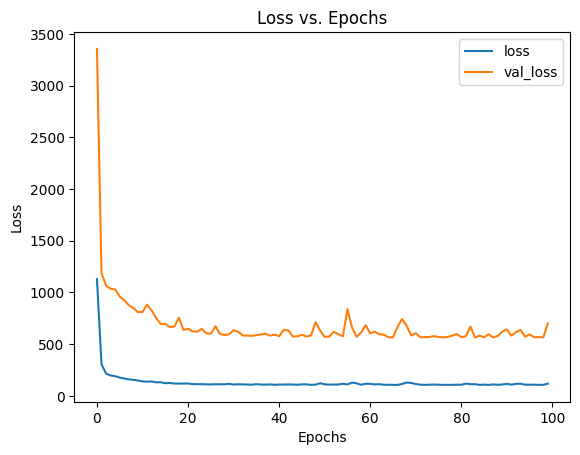

In [47]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')

In [48]:
# Load in Best Weights from Checkpoint
model_1.load_weights(model_1_best_weights_checkpoint.filepath)
model_1.evaluate(test_windows_w7_h1, test_labels_w7_h1)

18/18 [==============================] - 0s 5ms/step - loss: 564.6193 - mae: 564.6193 - mse: 1156819.6250


[564.6193237304688, 564.6193237304688, 1156819.625]

In [49]:
# Performance
model_1_performance = performance_toolbox.model.time_predictions(model_1, test_windows_w7_h1, name=model_1_name)
model_1_performance

18/18 [==============================] - 0s 1ms/step


2023-09-10 15:47:29.308295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.0950425000000017, total_predictions=556, name='model_1_dense_w7_h1')

In [50]:
# Predictions
model_1_preds = make_predictions(model_1, test_windows_w7_h1)
model_1_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_w7_h1, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_1_preds, tf.float32)),
                                                                             name=model_1_name)
model_1_results

18/18 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=564.6194, mse=1156819.9, rmse=1075.5557, mape=2.5089412, mase=0.99187976, huber=564.1206, name='model_1_dense_w7_h1')

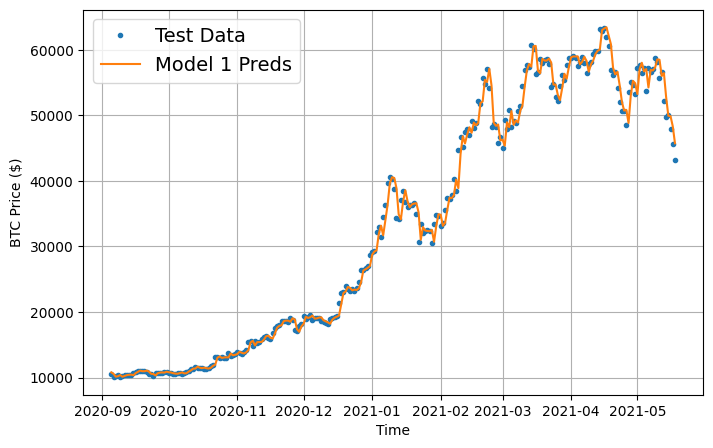

In [51]:
# Viewing Predictions
offset = 300
plt.figure(figsize=(8,5))
plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w7_h1):],
    values=test_labels_w7_h1[:, 0],
    start=offset,
    label='Test Data',
    new_figure=False)

plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w7_h1):],
    values=model_1_preds,
    start=offset,
    format='-',
    label='Model 1 Preds',
    new_figure=False)

### Model-2: Dense Model (Horizon=1, Window=30)

This model will be a simple Dense model with the following parameters

* Single Dense layer with 128 hidden units and ReLU
* Output Layer with linear activation (no activation)
* Adam Optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [52]:
# Constants
model_2_name = 'model_2_dense_w30_h1'

In [53]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE_30,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON_1, activation='linear'),
], name=model_2_name)

model_2.summary()

Model: "model_2_dense_w30_h1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# Compile Model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [55]:
# Fit Model
model_2_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_2_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_2_history = model_2.fit(train_windows_w30_h1,
                              train_labels_w30_h1,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_w30_h1, test_labels_w30_h1),
                              callbacks=[model_2_best_weights_checkpoint])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 1322.4662 - mae: 1322.4662 - mse: 6729586.0000 

2023-09-10 15:47:29.789752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1151.1436 - mae: 1151.1436 - mse: 5428464.5000
Epoch 1: val_loss improved from inf to 4696.17627, saving model to checkpoints/model_2_dense_w30_h1/20230910-154729/checkpoint.ckpt
18/18 [==============================] - 0s 16ms/step - loss: 1151.1436 - mae: 1151.1436 - mse: 5428464.5000 - val_loss: 4696.1763 - val_mae: 4696.1763 - val_mse: 53346368.0000
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 677.0458 - mae: 677.0458 - mse: 1972267.5000

2023-09-10 15:47:30.047953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 4696.17627 to 2432.28931, saving model to checkpoints/model_2_dense_w30_h1/20230910-154729/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 629.6642 - mae: 629.6642 - mse: 1750251.6250 - val_loss: 2432.2893 - val_mae: 2432.2893 - val_mse: 16050410.0000
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 487.9347 - mae: 487.9347 - mse: 1025239.2500
Epoch 3: val_loss improved from 2432.28931 to 1826.36365, saving model to checkpoints/model_2_dense_w30_h1/20230910-154729/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 460.7545 - mae: 460.7545 - mse: 973534.3125 - val_loss: 1826.3636 - val_mae: 1826.3636 - val_mse: 9108417.0000
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 331.5459 - mae: 331.5459 - mse: 521586.4688
Epoch 4: val_loss improved from 1826.36365 to 1385.25134, saving model to checkpoints/model_2_dense_w30_h1/20230910-154729/checkpoint.ckpt
18/18 [==

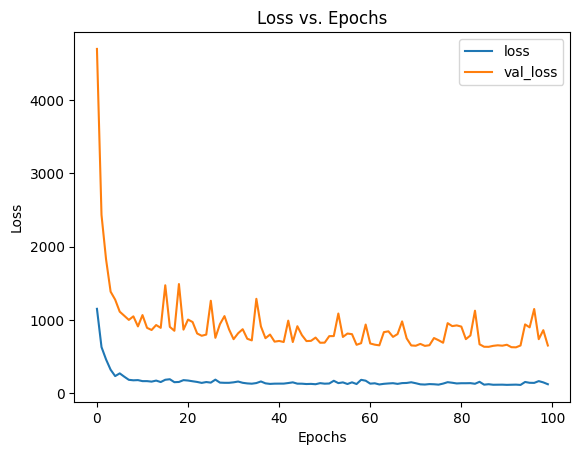

In [56]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')

In [57]:
# Load in Best Weights from Checkpoint
model_2.load_weights(model_2_best_weights_checkpoint.filepath)
model_2.evaluate(test_windows_w30_h1, test_labels_w30_h1)

18/18 [==============================] - 0s 5ms/step - loss: 626.0106 - mae: 626.0106 - mse: 1289388.0000


[626.0105590820312, 626.0105590820312, 1289388.0]

In [58]:
# Performance
model_2_performance = performance_toolbox.model.time_predictions(model_2, test_windows_w30_h1, name=model_2_name)
model_2_performance

18/18 [==============================] - 0s 2ms/step


2023-09-10 15:47:43.529695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.08208841600000483, total_predictions=552, name='model_2_dense_w30_h1')

In [59]:
# Predictions
model_2_preds = make_predictions(model_2, test_windows_w30_h1)
model_2_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_w30_h1, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_2_preds, tf.float32)),
                                                                             name=model_2_name)
model_2_results

18/18 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=626.0105, mse=1289388.1, rmse=1135.5123, mape=2.9079008, mase=1.0942725, huber=625.51074, name='model_2_dense_w30_h1')

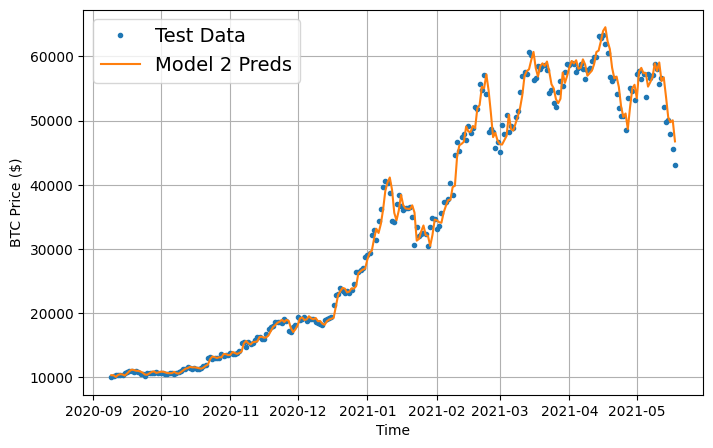

In [60]:
# Viewing Predictions
offset = 300
plt.figure(figsize=(8,5))
plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w30_h1):],
    values=test_labels_w30_h1[:, 0],
    start=offset,
    label='Test Data',
    new_figure=False)

plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w30_h1):],
    values=model_2_preds,
    start=offset,
    format='-',
    label='Model 2 Preds',
    new_figure=False)

### Model-3: Dense Model (Horizon=7, Window=30)

This model will be a simple Dense model with the following parameters

* Single Dense layer with 128 hidden units and ReLU
* Output Layer with linear activation (no activation)
* Adam Optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [61]:
# Constants
model_3_name = 'model_3_dense_w30_h7'

In [62]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE_30,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON_7, activation='linear'),
], name=model_3_name)

model_3.summary()

Model: "model_3_dense_w30_h7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4871 (19.03 KB)
Trainable params: 4871 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Compile Model
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [64]:
# Fit Model
model_3_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_3_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_3_history = model_3.fit(train_windows_w30_h7,
                              train_labels_w30_h7,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_w30_h7, test_labels_w30_h7),
                              callbacks=[model_3_best_weights_checkpoint])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2119.7671 - mae: 2119.7671 - mse: 22288070.0000

2023-09-10 15:47:44.012105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1550.1707 - mae: 1550.1707 - mse: 14153543.0000
Epoch 1: val_loss improved from inf to 4107.06738, saving model to checkpoints/model_3_dense_w30_h7/20230910-154743/checkpoint.ckpt
18/18 [==============================] - 0s 17ms/step - loss: 1550.1707 - mae: 1550.1707 - mse: 14153543.0000 - val_loss: 4107.0674 - val_mae: 4107.0674 - val_mse: 50836140.0000
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 557.7867 - mae: 557.7867 - mse: 1481899.7500

2023-09-10 15:47:44.303389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 4107.06738 to 2019.90784, saving model to checkpoints/model_3_dense_w30_h7/20230910-154743/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 542.9081 - mae: 542.9081 - mse: 1411876.0000 - val_loss: 2019.9078 - val_mae: 2019.9078 - val_mse: 11998611.0000
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 424.1865 - mae: 424.1865 - mse: 843358.0625
Epoch 3: val_loss did not improve from 2019.90784
18/18 [==============================] - 0s 7ms/step - loss: 414.0388 - mae: 414.0388 - mse: 847870.7500 - val_loss: 2096.7671 - val_mae: 2096.7671 - val_mse: 13328998.0000
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 366.2845 - mae: 366.2845 - mse: 689372.4375
Epoch 4: val_loss improved from 2019.90784 to 1904.21619, saving model to checkpoints/model_3_dense_w30_h7/20230910-154743/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 368.4480 - mae: 368.4480 - mse: 68341

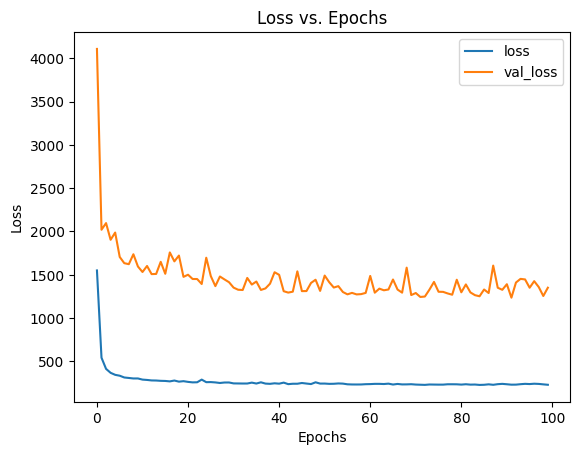

In [65]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')

In [66]:
# Load in Best Weights from Checkpoint
model_3.load_weights(model_3_best_weights_checkpoint.filepath)
model_3.evaluate(test_windows_w30_h7, test_labels_w30_h7)

18/18 [==============================] - 0s 6ms/step - loss: 1236.0518 - mae: 1236.0518 - mse: 5398413.0000


[1236.0517578125, 1236.0517578125, 5398413.0]

In [67]:
# Performance
model_3_performance = performance_toolbox.model.time_predictions(model_3, test_windows_w30_h7, name=model_3_name)
model_3_performance

18/18 [==============================] - 0s 2ms/step


2023-09-10 15:47:58.500333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.08061370899999787, total_predictions=551, name='model_3_dense_w30_h7')

In [68]:
# Predictions
model_3_preds = make_predictions(model_3, test_windows_w30_h7)
model_3_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_w30_h7, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_3_preds, tf.float32)),
                                                                             name=model_3_name)
model_3_results

18/18 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=1236.0518, mse=5398413.5, rmse=1432.8201, mape=5.744262, mase=2.1941037, huber=1235.552, name='model_3_dense_w30_h7')

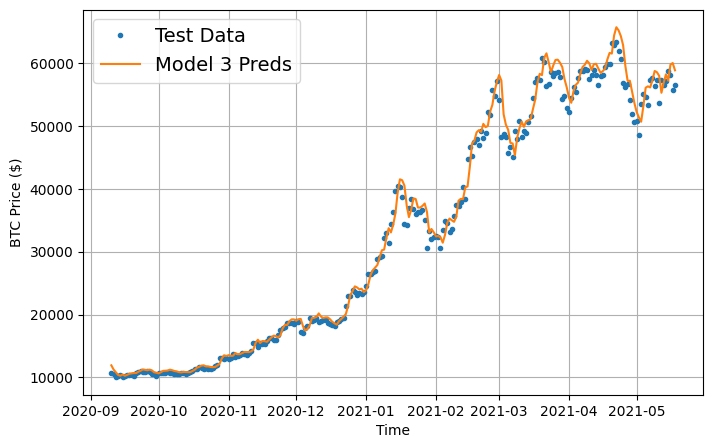

In [69]:
# Viewing Predictions
offset = 300
plt.figure(figsize=(8,5))
plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w30_h7):],
    values=test_labels_w30_h7[:, 0],
    start=offset,
    label='Test Data',
    new_figure=False)

# Need to aggregate the predictions
plot_timeseries(
    timesteps=timestamp_test[-len(test_windows_w30_h7):],
    values=tf.reduce_mean(model_3_preds, axis=1),
    start=offset,
    format='-',
    label='Model 3 Preds',
    new_figure=False)

### Model-4: Conv1D (Horizon=1, Window=7)

NOTE: The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

* `batch_size` = BATCH_SIZE - constant defined in constants section
* `timesteps` = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin
* `input_dim` = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [70]:
# Constants
model_4_name = 'model_4_conv1d'

In [71]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

# Need to reshape the input to Conv1D to be shape=(batch_size, window_size, horizon).
# Batch size is handled automatically when fitting data, so all I need to worry about is make sure
# the input shape to the Conv1D layer is shape=(window_size, horizon).
# To do this, due to horizon=1, I can just expand the dims to make a bath shape as (7, 1) for the input into the Conv1D layer
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE_7,)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='reshape_layer'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    # tf.keras.layers.GlobalAveragePooling1D(),  # Wasn't needed for some reason
    tf.keras.layers.Dense(HORIZON_1, activation='linear'),
], name=model_4_name)

model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_layer (Lambda)      (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Compile Model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [73]:
# Fit Model
model_4_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_4_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_4_history = model_4.fit(train_windows_w7_h1,
                              train_labels_w7_h1,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_w7_h1, test_labels_w7_h1),
                              callbacks=[model_4_best_weights_checkpoint])

Epoch 1/100
 8/18 [============>.................] - ETA: 0s - loss: 2456.0010 - mae: 2456.0010 - mse: 15098389.0000

2023-09-10 15:47:59.098701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/18 [=========================>....] - ETA: 0s - loss: 1852.7554 - mae: 1852.7554 - mse: 9622704.0000 
Epoch 1: val_loss improved from inf to 1800.12024, saving model to checkpoints/model_4_conv1d/20230910-154758/checkpoint.ckpt
18/18 [==============================] - 1s 20ms/step - loss: 1751.9629 - mae: 1751.9629 - mse: 8941998.0000 - val_loss: 1800.1202 - val_mae: 1800.1202 - val_mse: 7796415.5000
Epoch 2/100
 9/18 [==============>...............] - ETA: 0s - loss: 345.5080 - mae: 345.5080 - mse: 470243.1250

2023-09-10 15:47:59.439784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 320.5893 - mae: 320.5893 - mse: 408909.7500
Epoch 2: val_loss improved from 1800.12024 to 1503.06750, saving model to checkpoints/model_4_conv1d/20230910-154758/checkpoint.ckpt
18/18 [==============================] - 0s 10ms/step - loss: 316.8835 - mae: 316.8835 - mse: 401534.8125 - val_loss: 1503.0675 - val_mae: 1503.0675 - val_mse: 5766125.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 226.8446 - mae: 226.8446 - mse: 245727.9375
Epoch 3: val_loss improved from 1503.06750 to 1061.32178, saving model to checkpoints/model_4_conv1d/20230910-154758/checkpoint.ckpt
18/18 [==============================] - 0s 10ms/step - loss: 225.0139 - mae: 225.0139 - mse: 243986.0156 - val_loss: 1061.3218 - val_mae: 1061.3218 - val_mse: 3761523.2500
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 192.5198 - mae: 192.5198 - mse: 193938.7656
Epoch 4: val_loss improved from 1061.32178 to 1055.72302, sav

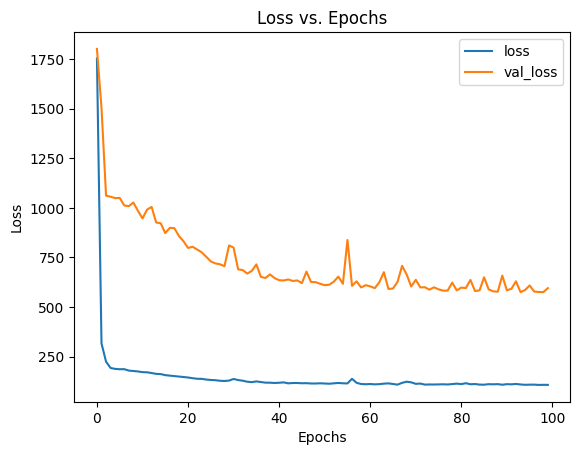

In [74]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')

In [75]:
# Load in Best Weights from Checkpoint
model_4.load_weights(model_4_best_weights_checkpoint.filepath)
model_4.evaluate(test_windows_w7_h1, test_labels_w7_h1)

18/18 [==============================] - 0s 7ms/step - loss: 575.3289 - mae: 575.3289 - mse: 1195277.6250


[575.3289184570312, 575.3289184570312, 1195277.625]

In [76]:
# Performance
model_4_performance = performance_toolbox.model.time_predictions(model_4, test_windows_w7_h1, name=model_4_name)
model_4_performance

18/18 [==============================] - 0s 3ms/step


2023-09-10 15:48:17.471236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.13024129100000437, total_predictions=556, name='model_4_conv1d')

In [77]:
# Predictions
model_4_preds = make_predictions(model_4, test_windows_w7_h1)
model_4_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_w7_h1, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_4_preds, tf.float32)),
                                                                             name=model_4_name)
model_4_results

18/18 [==============================] - 0s 3ms/step


RegressionPredictionMetrics(mae=575.3289, mse=1195277.8, rmse=1093.2876, mape=2.5671804, mase=1.0106934, huber=574.82996, name='model_4_conv1d')

### Model-5: LSTM (Horizon=1, Window=7)

The LSTM model can be used to predict sequential timesseries data.

The TensorFlow LSTM layer requires an input shape of `[batch, timesteps, feature]`. The `batch` is already handled within the model directly, but the shape of the input to the LSTM layer needs to be reshaped to include an additional dimension due to the horizon being size 1. To fix this, just like the Conv1D model, the `tf.keras.layers.Lambda()` layer can be used to adjust the shape of the input tensors to the LSTM layer.

In [78]:
# Constants
model_5_name = 'model_5_lstm'

In [79]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE_7,))
reshape_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='reshape_layer')(inputs)
lstm_layer = tf.keras.layers.LSTM(128, activation='relu')(reshape_layer)
outputs = tf.keras.layers.Dense(HORIZON_1, activation='linear')(lstm_layer)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_5_name)

model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 reshape_layer (Lambda)      (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69761 (272.50 KB)
Trainable params: 69761 (272.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
# Compile Model
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [81]:
# Fit Model
model_5_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_5_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_5_history = model_5.fit(train_windows_w7_h1,
                              train_labels_w7_h1,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_w7_h1, test_labels_w7_h1),
                              callbacks=[model_5_best_weights_checkpoint])

Epoch 1/100


2023-09-10 15:48:18.101433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2339.0144 - mae: 2339.0144 - mse: 13562868.0000
Epoch 1: val_loss improved from inf to 10536.32520, saving model to checkpoints/model_5_lstm/20230910-154817/checkpoint.ckpt
18/18 [==============================] - 1s 33ms/step - loss: 2339.0144 - mae: 2339.0144 - mse: 13562868.0000 - val_loss: 10536.3252 - val_mae: 10536.3252 - val_mse: 197158992.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1271.6539 - mae: 1271.6539 - mse: 4928204.0000

2023-09-10 15:48:18.729486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 660.8962 - mae: 660.8962 - mse: 1730855.5000
Epoch 2: val_loss improved from 10536.32520 to 1756.26636, saving model to checkpoints/model_5_lstm/20230910-154817/checkpoint.ckpt
18/18 [==============================] - 0s 17ms/step - loss: 652.1744 - mae: 652.1744 - mse: 1697915.8750 - val_loss: 1756.2664 - val_mae: 1756.2664 - val_mse: 8531317.0000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 238.7341 - mae: 238.7341 - mse: 246165.5781
Epoch 3: val_loss improved from 1756.26636 to 1351.02917, saving model to checkpoints/model_5_lstm/20230910-154817/checkpoint.ckpt
18/18 [==============================] - 0s 17ms/step - loss: 238.7341 - mae: 238.7341 - mse: 246165.5781 - val_loss: 1351.0292 - val_mae: 1351.0292 - val_mse: 4870133.0000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 195.0468 - mae: 195.0468 - mse: 196291.6406
Epoch 4: val_loss improved from 1351.02917 to 1070.87561, savi

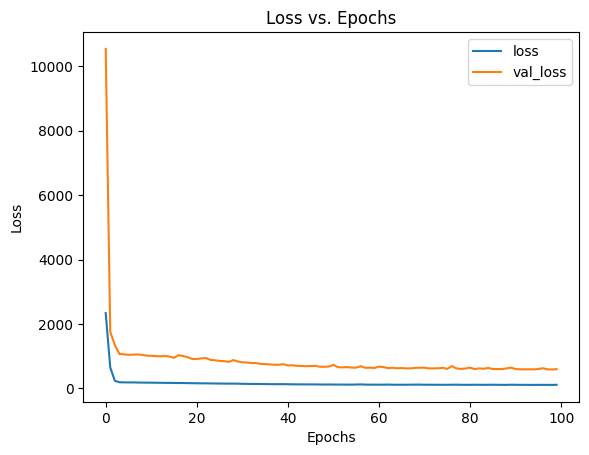

In [82]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_5_history, 'loss')

In [83]:
# Load in Best Weights from Checkpoint
model_5.load_weights(model_5_best_weights_checkpoint.filepath)
model_5.evaluate(test_windows_w7_h1, test_labels_w7_h1)

18/18 [==============================] - 0s 9ms/step - loss: 589.0396 - mae: 589.0396 - mse: 1243140.7500


[589.03955078125, 589.03955078125, 1243140.75]

In [84]:
# Performance
model_5_performance = performance_toolbox.model.time_predictions(model_5, test_windows_w7_h1)
model_5_performance

18/18 [==============================] - 0s 5ms/step


2023-09-10 15:48:48.017861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.20399175000000014, total_predictions=556, name=None)

In [85]:
# Predictions
model_5_preds = make_predictions(model_5, test_windows_w7_h1)
model_5_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_w7_h1, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_5_preds, tf.float32)),
                                                                             name=model_5_name)
model_5_results

18/18 [==============================] - 0s 4ms/step


RegressionPredictionMetrics(mae=589.0396, mse=1243140.9, rmse=1114.9623, mape=2.6528945, mase=1.0347793, huber=588.5398, name='model_5_lstm')

### Model-6: Dense w/ Multivariate Data

Multivariate data is using more than one feature to train on.

Before I can add a feature to the timeseries, I need to identify the features that can be used. Some features that could be used are listed below:
* Whether bitcoin was tweeted about by an influential person that day.
* Number of days after a 'bitcoin halving date'.
* Block reward for the given date.

For this project, I am going to look at the bitcoin halving dates as an additional feature for the multivariate timeseries. Specifically, the value of the block reqThe data I grabbed comes from the following link:
* https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [86]:
# Constants
model_6_name = 'model_6_dense_multivariate'

# Creating Input Size as the Window Size of 7, plus the additional variable (block_reward)
INPUT_SIZE_MV = WINDOW_SIZE_7 + 1

In [87]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE_MV,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON_1, activation='linear'),
], name=model_6_name)

model_6.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1152      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Compile Model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [89]:
# Fit Model
model_6_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_6_name,
                                                                                             monitor='val_loss',
                                                                                             best_only=True)

model_6_history = model_6.fit(train_windows_mv,
                              train_labels_mv,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows_mv, test_labels_mv),
                              callbacks=[model_6_best_weights_checkpoint])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 3687.8665 - mae: 3687.8665 - mse: 34131240.0000

2023-09-10 15:48:48.539134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2819.2815 - mae: 2819.2815 - mse: 22716782.0000
Epoch 1: val_loss improved from inf to 3049.77881, saving model to checkpoints/model_6_dense_multivariate/20230910-154848/checkpoint.ckpt
18/18 [==============================] - 0s 15ms/step - loss: 2819.2815 - mae: 2819.2815 - mse: 22716782.0000 - val_loss: 3049.7788 - val_mae: 3049.7788 - val_mse: 18499642.0000
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 467.9611 - mae: 467.9611 - mse: 723835.5625

2023-09-10 15:48:48.794172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 3049.77881 to 1650.94348, saving model to checkpoints/model_6_dense_multivariate/20230910-154848/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 401.6819 - mae: 401.6819 - mse: 573251.2500 - val_loss: 1650.9435 - val_mae: 1650.9435 - val_mse: 6410091.0000
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 242.7709 - mae: 242.7709 - mse: 258491.2344
Epoch 3: val_loss improved from 1650.94348 to 1040.48401, saving model to checkpoints/model_6_dense_multivariate/20230910-154848/checkpoint.ckpt
18/18 [==============================] - 0s 8ms/step - loss: 231.6198 - mae: 231.6198 - mse: 241312.2031 - val_loss: 1040.4840 - val_mae: 1040.4840 - val_mse: 3193428.0000
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 189.4780 - mae: 189.4780 - mse: 185459.2031
Epoch 4: val_loss improved from 1040.48401 to 956.92865, saving model to checkpoints/model_6_dense_multivariate/20230910-154848/checkpoint.

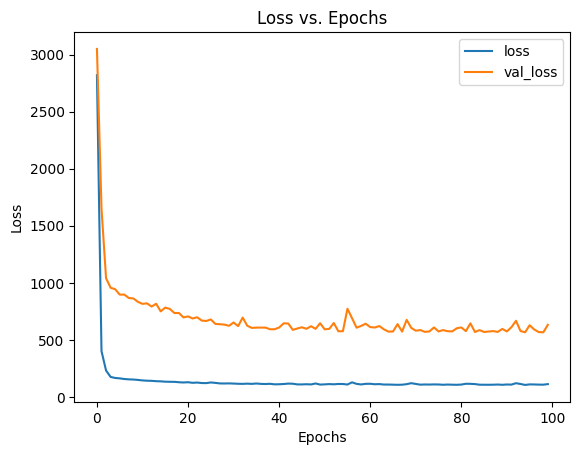

In [90]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_6_history, 'loss')

In [91]:
# Load in Best Weights from Checkpoint
model_6.load_weights(model_6_best_weights_checkpoint.filepath)
model_6.evaluate(test_windows_mv, test_labels_mv)

18/18 [==============================] - 0s 5ms/step - loss: 566.3740 - mae: 566.3740 - mse: 1157861.6250


[566.3740234375, 566.3740234375, 1157861.625]

In [92]:
# Performance
model_6_performance = performance_toolbox.model.time_predictions(model_6, test_windows_mv, name=model_6_name)
model_6_performance

18/18 [==============================] - 0s 1ms/step


2023-09-10 15:49:02.404673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Performance(total_time=0.07496470899999963, total_predictions=556, name='model_6_dense_multivariate')

In [93]:
# Predictions
model_6_preds = make_predictions(model_6, test_windows_mv)
model_6_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(test_labels_mv, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_6_preds, tf.float32)),
                                                                             name=model_6_name)
model_6_results

18/18 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=566.3741, mse=1157861.8, rmse=1076.0398, mape=2.5121677, mase=0.9949623, huber=565.8741, name='model_6_dense_multivariate')

### Model-7: N-BEATS Algorithm (Horizon=1, Window=7)

The N-Beats Time-Series forecasting model is a powerful model that focuses on univariate time-series problems that achieved state-of-the-art performance ans was the winner of the M4 competition (see link below).

* https://towardsdatascience.com/n-beats-time-series-forecasting-with-neural-basis-expansion-af09ea39f538

For this model, I am going to replicate the generic architecture of the N-Beats algorithm (section 3.3 of [linked paper](https://arxiv.org/pdf/1905.10437.pdf)). Specifically, I will be replicating the algorithm in Figure 1. The purpose of this is for the following reasons:
* This will give me practice replicating a paper with TensorFlow code.
* This requires TensorFlow layer subclassing (custom layers).
* This uses the functional API for creating custom architectures.

In [94]:
# Constants
model_7_name = 'model_7_n_beats'

# Hyperparameters (Values from N-BEATS paper Figure 1 and Table 18/Appendix D)
EPOCHS_N_BEATS = 5000
NEURONS_N_BEATS = 512
LAYERS_N_BEATS = 4
STACKS_N_BEATS = 30

INPUT_SIZE_N_BEATS = WINDOW_SIZE_7 * HORIZON_1
THETA_SIZE_N_BEATS = INPUT_SIZE_N_BEATS + HORIZON_1

INPUT_SIZE_N_BEATS, THETA_SIZE_N_BEATS

(7, 8)

##### Build N-BEATS Layer

The N-Beats block layer doesn't exist in TensorFlow, so I will be creating it by subclassing the TensorFlow `Layer` class.

In [95]:
class NBeatsBlock(tf.keras.layers.Layer):
    """ Layer class that represents a fully constructed N-BEATS algorithm layer.

        Public Attributes:
            input_size (int):
            theta_size (int):
            horizon (int):
            n_neurons (int):
            n_layers (int):

        Private Attributes:
            _hidden_layers (typing.List[tf.keras.layers.Dense]):
            _theta_layer (tf.keras.layers.Dense):
    """
    
    def __init__(self, 
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 *args,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self._hidden_layers = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        self._theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs: tf.Tensor) -> typing.Tuple[tf.Tensor, tf.Tensor]:
        """ Abstract attribute called be the super class when calling an instance.

            Args:
                inputs (tf.Tensor): the inputs to run through the layer.

            Returns:
                (typing.Tuple[tf.Tensor, tf.Tensor]) the backcast and forecast of the inputs.
        """
        x = inputs
        for layer in self._hidden_layers:
          x = layer(x)

        theta = self._theta_layer(x)

        # Output the backcast and the forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast

In [96]:
# Testing n_beats model
tf.random.set_seed(42)

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE_7,
                                       theta_size=WINDOW_SIZE_7+HORIZON_1, # backcast + forecast
                                       horizon=HORIZON_1,
                                       n_neurons=128,
                                       n_layers=4)

In [97]:
# Create dummy inputs (have to be same size as input_size)
# input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE_7) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [98]:
# Testing outputs
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.48953772  0.3049147  -0.38053223  0.16077533  0.37459615 -0.07973033
  0.6573233 ]
Forecast: 0.7568225264549255


##### Setting Up, Building, Compiling, & Fitting Model

Now that I have a dataset and layer for the N-BEATS algorithm, I am ready to build and test the model.

1. Create an Input layer for the N-BEATS stack.
2. Setup instance of the N-BEATS Block layer using `NBeatsBlock` class (this'll be the initial block used for the network, the rest will be created as part of stacks).
3. Make the initial backcast and forecasts for the model with the layer created in step-1.
4. Use for loop to create stacks of block layers.
5. Use the `NBeatsBlock` class within the for loop in step-4 to creat blocks which return backcast and forecasts.
6. Create the double residual stacking using subtract and add layers.
7. Put the model inputs and outputs together using TensorFlow functional API.
8. Compile model with MAY loss, and Adam optimizer with default settings as in section 5.2 in N-BEATS paper.
9. Fit the N-BEATS for 5000 epochs, with the following callbacks.
   * EarlyStopping Callback - because the model will be training for so long, we'll stop it early if it stops improving.
   * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance).

In [99]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

# 1. Create input layer for NBeatsBlock layer
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE_N_BEATS,), name='stack_input')

# 2. Create NBeatsBlock Layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE_N_BEATS,
                                 theta_size=THETA_SIZE_N_BEATS,
                                 horizon=HORIZON_1,
                                 n_neurons=NEURONS_N_BEATS,
                                 n_layers=LAYERS_N_BEATS,
                                 name='initial_block')

# 3. Create initial backcast and forecast input (backward prediction + horizon prediction)
backcast, forecast = nbeats_block_layer(stack_input)
residuals = tf.keras.layers.subtract([stack_input, backcast], name='subtract_00')

# 4. Create Stacks of Black Layers
for i, _ in enumerate(range(STACKS_N_BEATS-1)):
    # 5. Use NBeatsBlock to calculate backcast and forecast
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE_N_BEATS,
                                           theta_size=THETA_SIZE_N_BEATS,
                                           horizon=HORIZON_1,
                                           n_neurons=NEURONS_N_BEATS,
                                           n_layers=LAYERS_N_BEATS,
                                           name=f'nbeats_block_{i}')(residuals)

    # 6. Create Double Residual Stacking
    residuals = tf.keras.layers.subtract([residuals, backcast], name=f'subtract_{i}')
    forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Create Model
model_7 = tf.keras.models.Model(stack_input, forecast, name=model_7_name)
model_7.summary()

Model: "model_7_n_beats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 initial_block (NBeatsBlock  ((None, 7),                  796168    ['stack_input[0][0]']         
 )                            (None, 1))                                                          
                                                                                                  
 subtract_00 (Subtract)      (None, 7)                    0         ['stack_input[0][0]',         
                                                                     'initial_block[0][0]']       
                                                                                    

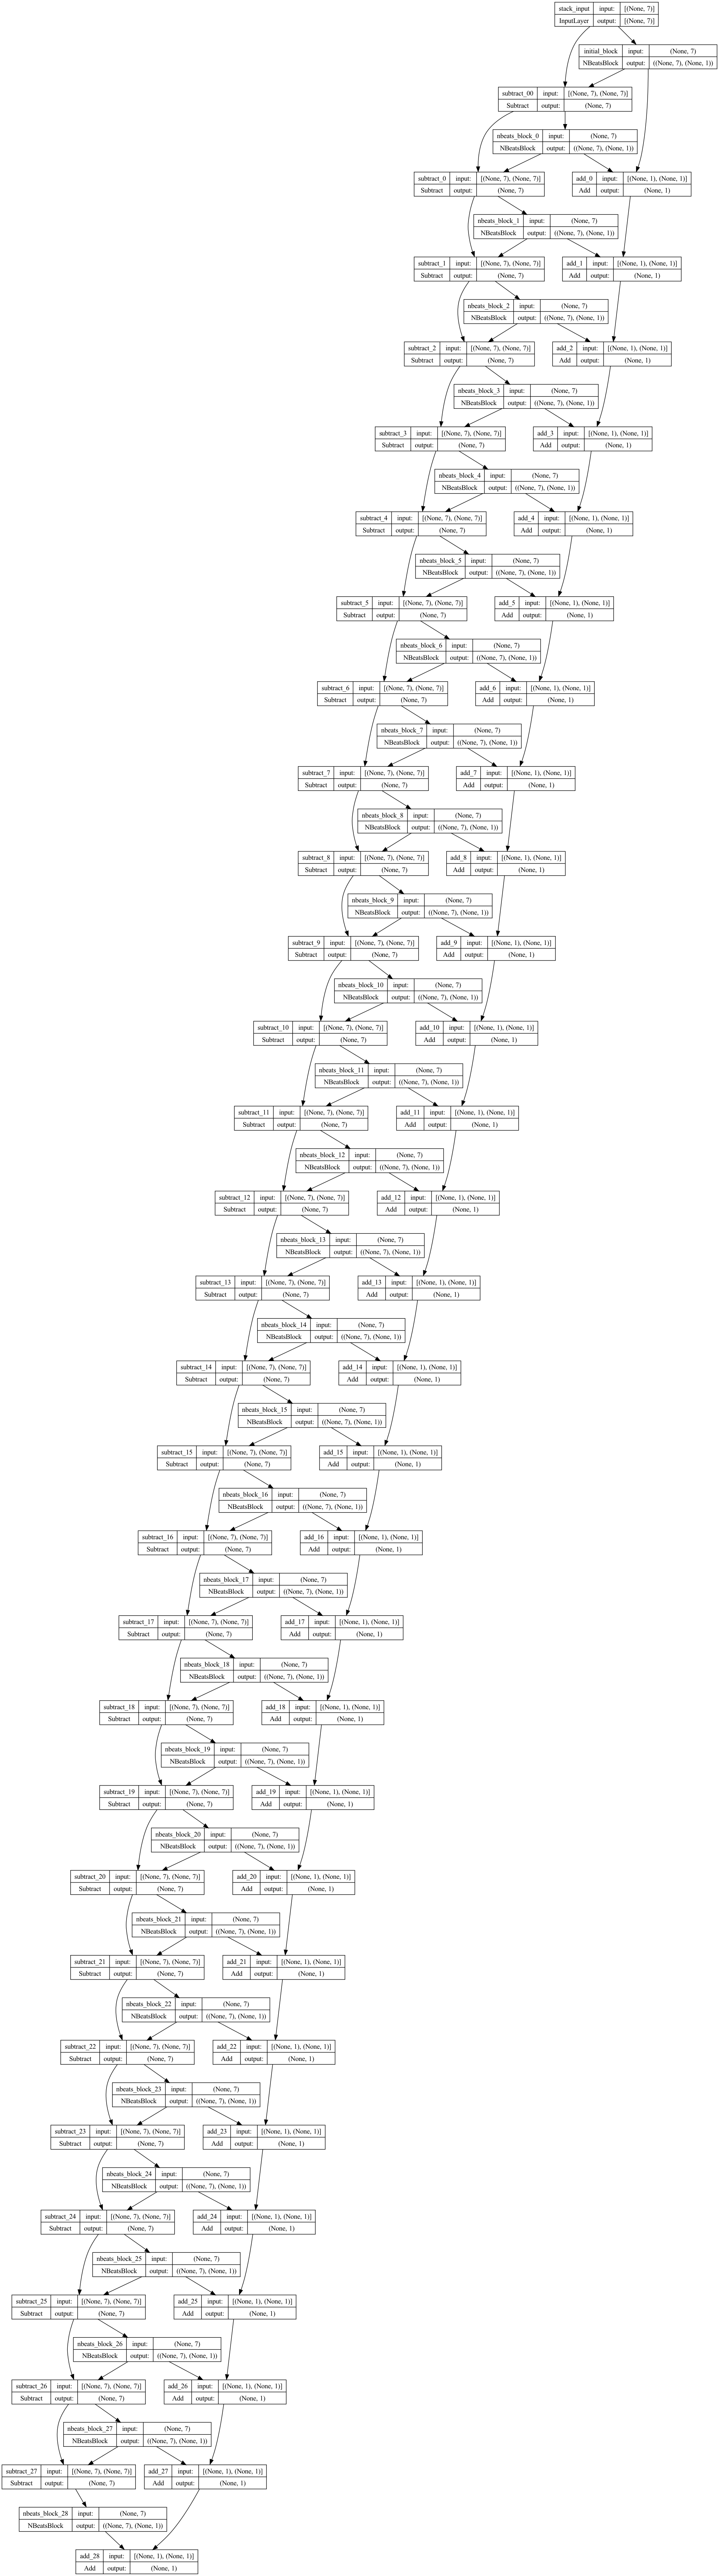

In [100]:
ml_toolbox.analysis.model.plot_model(model_7)

In [101]:
# Compile Model
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=['mae', 'mse'])

In [102]:
# Fit Model
model_7_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
model_7_reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1)

model_7_history = model_7.fit(train_dataset_large_batch,
                              epochs=EPOCHS_N_BEATS,
                              validation_data=test_dataset_large_batch,
                              callbacks=[model_7_early_stopping,
                                         model_7_reduce_lr_plateau])

Epoch 1/5000


2023-09-10 15:49:06.684121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 19901.6328 - mae: 19901.6328 - mse: 1135905792.0000

2023-09-10 15:49:11.909059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 8s 1s/step - loss: 19901.6328 - mae: 19901.6328 - mse: 1135905792.0000 - val_loss: 57342.9922 - val_mae: 57342.9922 - val_mse: 5817766912.0000 - lr: 1.0000e-04
Epoch 2/5000
3/3 [==============================] - 1s 223ms/step - loss: 11542.2109 - mae: 11542.2109 - mse: 346812992.0000 - val_loss: 80681.3516 - val_mae: 80681.3516 - val_mse: 11490137088.0000 - lr: 1.0000e-04
Epoch 3/5000
3/3 [==============================] - 1s 242ms/step - loss: 28940.1211 - mae: 28940.1211 - mse: 2215929088.0000 - val_loss: 157800.8125 - val_mae: 157800.8125 - val_mse: 43943149568.0000 - lr: 1.0000e-04
Epoch 4/5000
3/3 [==============================] - 1s 190ms/step - loss: 13746.6572 - mae: 13746.6572 - mse: 443008992.0000 - val_loss: 57713.3867 - val_mae: 57713.3867 - val_mse: 5932023296.0000 - lr: 1.0000e-04
Epoch 5/5000
3/3 [==============================] - 0s 132ms/step - loss: 22826.9922 - mae: 22826.9922 - mse: 1436833152.0000 - val_loss: 149163.3125 - va

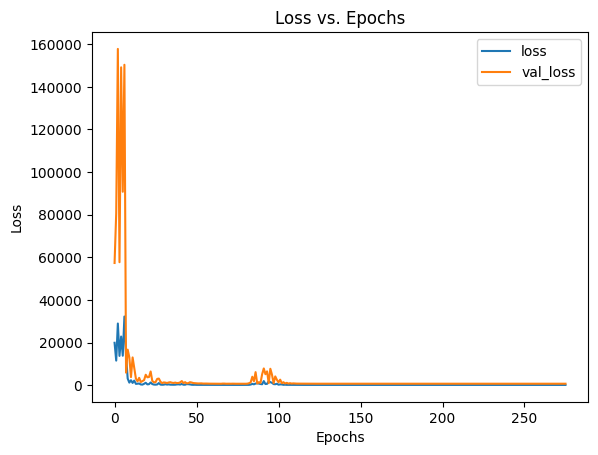

In [103]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_7_history, 'loss')

In [104]:
# Performance
model_7_performance = performance_toolbox.model.time_predictions(model_7, test_dataset_large_batch, name=model_7_name)
model_7_performance

2023-09-10 15:50:41.878543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 866ms/step


Performance(total_time=0.900290874999996, total_predictions=1, name='model_7_n_beats')

In [105]:
# Predictions
model_7_preds = make_predictions(model_7, test_dataset_large_batch)

model_7_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(y_test_large_batch, tf.float32)),
                                                                             tf.squeeze(tf.cast(model_7_preds, tf.float32)),
                                                                             name=model_7_name)
                                                                             
model_7_results                                                         

1/1 [==============================] - 0s 24ms/step


RegressionPredictionMetrics(mae=671.8317, mse=1500288.1, rmse=1224.8625, mape=3.1077468, mase=1.1802222, huber=671.3317, name='model_7_n_beats')

### Model-8: Ensemble (Multiple Models Stacked together)

An Ensemble model leverages the wisdom of the croud effect. It combines different models to predict a common goal.

In [106]:
# Constants
model_8_name = 'model_8_ensemble'

EPOCHS_ENSEMBLE = 1000
ITERATIONS_ENSEMBLE = 5

In [107]:
# Build, Compile, and Fit Models
ensemble_models = get_ensemble_models(horizon=HORIZON_1,
                                      window_size=WINDOW_SIZE_7,
                                      train_data=train_dataset_large_batch,
                                      test_data=test_dataset_large_batch,
                                      num_iter=ITERATIONS_ENSEMBLE,
                                      num_epochs=EPOCHS_ENSEMBLE)

Optimizing model by reducing: mae for 1000, model number: 0


2023-09-10 15:50:42.740389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:50:43.092734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Optimizing model by reducing: mse for 1000, model number: 0


2023-09-10 15:51:18.958985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:51:19.271681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 438: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000, model number: 0


2023-09-10 15:51:57.668622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:51:58.010578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 191: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 813: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 922: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000, model number: 1


2023-09-10 15:52:37.028976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:52:37.278611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 292: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000, model number: 1


2023-09-10 15:53:12.284637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:53:12.598352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 763: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 863: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000, model number: 1


2023-09-10 15:53:46.167110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:53:46.514626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 205: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 479: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 592: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 692: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing: mae for 1000, model number: 2


2023-09-10 15:54:13.085451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:54:13.319097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 117: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000, model number: 2


2023-09-10 15:54:48.971062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:54:49.307248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 568: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 668: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000, model number: 2


2023-09-10 15:55:14.525298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:55:14.868039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 502: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000, model number: 3


2023-09-10 15:55:51.883564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:55:52.188778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 919: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000, model number: 3


2023-09-10 15:56:27.279879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:56:27.560998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 417: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000, model number: 3


2023-09-10 15:57:03.406176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:57:03.783246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 115: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 513: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 613: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000, model number: 4


2023-09-10 15:57:27.091495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:57:27.376170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 877: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000, model number: 4


2023-09-10 15:58:03.596957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:58:03.862650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Optimizing model by reducing: mape for 1000, model number: 4


2023-09-10 15:58:39.802673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:58:40.181298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 172: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 432: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 532: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [108]:
# Analyzing History
# TODO: Update the `get_ensemble_models` to support all the histories
# TODO: Add/update function to plot all histories on same plot

In [109]:
# Performance
# TODO: Make the `performance_toolbox.model.time_predictions` utility function support sending in multiple models

In [110]:
# Predictions
# NOTE: Generating the mean and median because when working with multiple models, this is the standard way to
# generate the reduced metric given all the predictions.
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset_large_batch)
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)  # tf does not have a median

model_8_results = ml_toolbox.analysis.regression.generate_prediction_metrics(
    tf.squeeze(tf.cast(y_test_large_batch.to_numpy(), tf.float32)),
    tf.squeeze(tf.cast(ensemble_preds, tf.float32)),
    name=model_8_name)

model_8_mean_results = ml_toolbox.analysis.regression.generate_prediction_metrics(
    tf.squeeze(tf.cast(y_test_large_batch.to_numpy(), tf.float32)),
    tf.squeeze(tf.cast(ensemble_mean, tf.float32)),
    name=f'{model_8_name}_mean')

model_8_median_results = ml_toolbox.analysis.regression.generate_prediction_metrics(
    tf.squeeze(tf.cast(y_test_large_batch.to_numpy(), tf.float32)),
    tf.squeeze(tf.cast(ensemble_median, tf.float32)),
    name=f'{model_8_name}_median')

model_8_results, model_8_mean_results, model_8_median_results

1/1 [==============================] - 0s 20ms/step


2023-09-10 15:59:00.963275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:00.990851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.017643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.041182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.065881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.091447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.116334: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 21ms/step


2023-09-10 15:59:01.165088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.190476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.215417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.248235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.272401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.296151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 15:59:01.320717: I tensorflow/core/grappler/optimizers/cust

(RegressionPredictionMetrics(mae=574.5568, mse=1177817.8, rmse=1085.04, mape=2.55471, mase=1.0093371, huber=574.0573, name='model_8_ensemble'),
 RegressionPredictionMetrics(mae=566.5471, mse=1158041.8, rmse=1076.1235, mape=2.51483, mase=0.99526626, huber=566.04755, name='model_8_ensemble_mean'),
 RegressionPredictionMetrics(mae=565.2816, mse=1154939.6, rmse=1074.6812, mape=2.5085638, mase=0.9930431, huber=564.7832, name='model_8_ensemble_median'))

##### Plotting Ensemble Prediction Intervals (Uncertainty Estimates)

So far, all the models have been making point predictions (give a single value as the prediction). A better way to help our confidence in our predictions is to provide a range of values.

For instance, instead of a prediction of $\text{\$50,000}$, the prediction is between $\text{\$48,000}$ and $\text{\$52,000}$.

To get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the prediction from a number of randomly initialized models.
2. Measure the standard deviation of the predictions.
3. Multiply the standard deviation by 1.96 (assuming the distribution is the Gaussian/Normal distribution).
   * 95% of observations fall within 1.96 standard deviations of the mean.
4. To get the prediction interval upper and lower bounds, add and subtract Step-3 from the mean/median made in the predictions from Step-1.

In [111]:
lower, upper = get_upper_lower(ensemble_preds)
lower[:5], upper[:5]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8795.731, 8758.669, 9007.177, 8666.003, 8648.167], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([8878.3545, 8845.716 , 9107.97  , 8818.587 , 8843.413 ],
       dtype=float32)>)

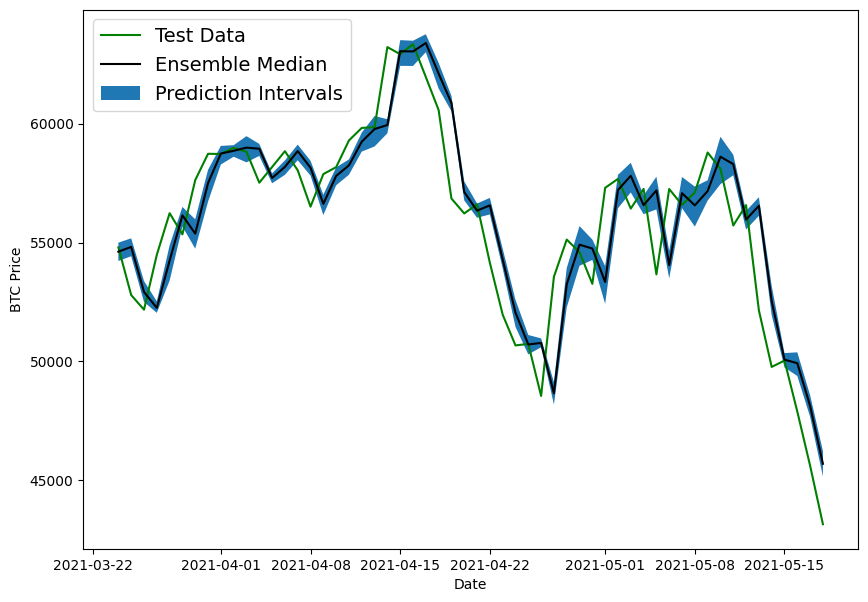

In [112]:
# plot the lower and upper bounds of predictions
ensemble_median = np.median(ensemble_preds, axis=0)

offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test_large_batch.index[offset:], y_test_large_batch[offset:], 'g', label='Test Data')
plt.plot(X_test_large_batch.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.fill_between(X_test_large_batch.index[offset:], (lower)[offset:], (upper)[offset:], label='Prediction Intervals')
plt.legend(loc='upper left', fontsize=14);

**Findings**

So far, all the model predictions have been lagging behind the test data. As is, they are replicating what the naive model does and just predict the previous timestep as the next timestep.

In short, so far all the models are basically predicting the price of bitcoin to be the same price as the previous days model (same as Naive Model).

### Model-9: Future Prediction Model

So far, all of the models have predicted on the test dataset, however, this is only a pseudofuture. In short, I am going to use all the available data to make future predictions.

In [113]:
# Constants
model_9_name = 'model_9_future_pred'

INTO_FUTURE = 14

In [114]:
# Build Model
tf.random.set_seed(RANDOM_SEED)

model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE_7,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON_1),
], name=model_9_name)

model_9.summary()

Model: "model_9_future_pred"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_179 (Dense)           (None, 128)               1024      
                                                                 
 dense_180 (Dense)           (None, 128)               16512     
                                                                 
 dense_181 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17665 (69.00 KB)
Trainable params: 17665 (69.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
# Compile Model
model_9.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

In [116]:
# Fit Model
model_9_history = model_9.fit(features_dataset_all,
                              epochs=100,
                              verbose=0)

2023-09-10 15:59:02.540909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


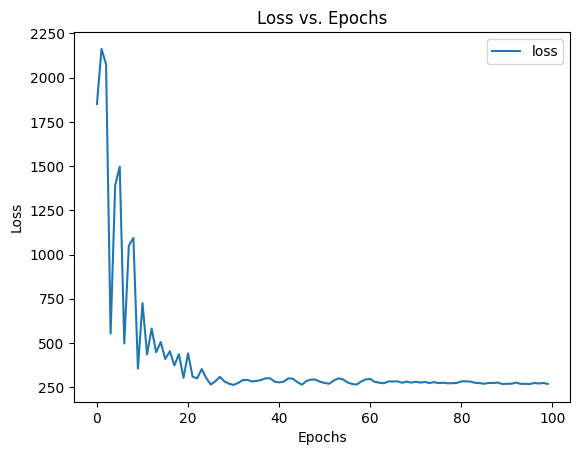

In [117]:
# Analyzing History
ml_toolbox.analysis.history.plot_history(model_9_history, 'loss')

##### Make Predictions into Future

To make predictions int the future, I need a function for the following:

1. Takes an input:
   * a list of values (bitcoin historical data)
   * a trained model
   * a window into the future to predict
   * the window size a model was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions). and extracts the last window size values from the input values.
3. Loop `INTO_FUTURE` times make a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.

In [118]:
future_forecast = make_future_forecasts(y_all, model_9, INTO_FUTURE, WINDOW_SIZE_7)
future_forecast

2023-09-10 15:59:05.566890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[55271.906,
 51659.645,
 49810.402,
 48443.793,
 47308.477,
 44159.625,
 46999.38,
 54246.203,
 51341.523,
 48969.82,
 47521.293,
 46158.895,
 44657.39,
 49340.64]

In [119]:
last_timestep = bitcoin_prices.index[-1]

next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
last_timestep, next_time_steps

(Timestamp('2021-05-18 00:00:00'),
 array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
        '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
        '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
        '2021-05-31', '2021-06-01'], dtype='datetime64[D]'))

In [120]:
# insert last timestep/final price into next time steps to make the plot connect
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55271.906, 51659.645, 49810.402, 48443.793, 47308.477,
        44159.625, 46999.38 , 54246.203, 51341.523, 48969.82 , 47521.293,
        46158.895, 44657.39 , 49340.64 ], dtype=float32))

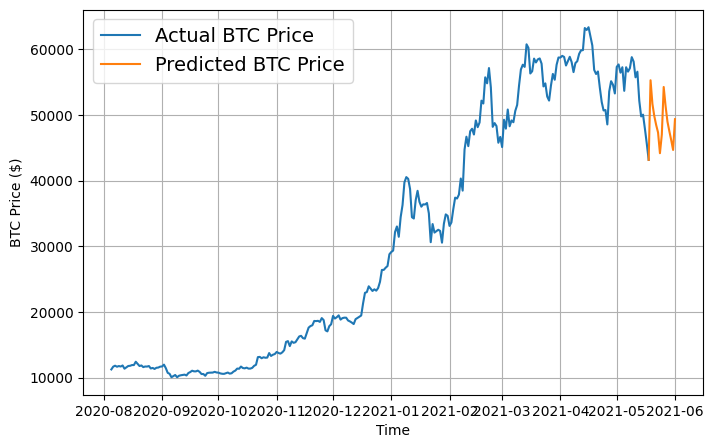

In [121]:
# Plot Fuiture Predictions
plt.figure(figsize=(8, 5))
plot_timeseries(bitcoin_prices.index, prices, start=2500, format='-', label='Actual BTC Price', new_figure=False)
plot_timeseries(next_time_steps, future_forecast, format='-', label='Predicted BTC Price', new_figure=False)

### Model-10: Dense w/ Turkey Data

The problem with timeseries forecasting is summarized but what is known as the Turkey problem. The issue is that you can completely model a significant time, but a single data point can completely disrupt the entire historical dataset.

The purpose of this is to show why forecasting models is BS.

In [122]:
# Constants
model_10_name = 'model_10_dense_turkey'

In [123]:
# Build Model
model_10 = tf.keras.models.clone_model(model_1)
model_10.summary()

Model: "model_1_dense_w7_h1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
# Compile Model
model_10.compile(loss='mae',
                 optimizer=tf.keras.optimizers.legacy.Adam(),
                 metrics=['mae', 'mse'])

In [125]:
# Fit Model
model_10_best_weights_checkpoint = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_10_name,
                                                                                              monitor='val_loss',
                                                                                              best_only=True)

model_10_history = model_10.fit(X_train_turkey,
                                y_train_turkey,
                                epochs=EPOCHS,
                                verbose=0,
                                batch_size=128,
                                validation_data=(X_test_turkey, y_test_turkey),
                                callbacks=[model_10_best_weights_checkpoint])

2023-09-10 15:59:06.296841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3591.97314, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt


2023-09-10 15:59:06.687569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 3591.97314 to 1787.81726, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 3: val_loss improved from 1787.81726 to 1478.67065, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 4: val_loss improved from 1478.67065 to 1270.88513, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 5: val_loss improved from 1270.88513 to 1259.45471, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 6: val_loss improved from 1259.45471 to 1217.62549, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 7: val_loss improved from 1217.62549 to 1199.82068, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 8: val_loss improved from 1199.82068 to 1123.93115, saving model to checkpoints/model_10_dense_turkey/20230910-155906/checkpoint.ckpt

Epoch 9: val

In [126]:
# Load in Best Weights from Checkpoint
model_10.load_weights(model_10_best_weights_checkpoint.filepath)
model_10.evaluate(X_test_turkey, y_test_turkey)

18/18 [==============================] - 0s 7ms/step - loss: 641.6654 - mae: 641.6654 - mse: 4883849.5000


[641.6654052734375, 641.6654052734375, 4883849.5]

In [127]:
# Predictions
model_10_preds = make_predictions(model_10, X_test_turkey)

print(f'Len X_Test: {len(X_test_turkey)} Len Preds {len(model_10_preds)} Actual {len(y_test_turkey)}')

print(f'Predicted Last Value: {model_10_preds[-1]} -> Turkey Problem Last Value: {y_test_turkey[-1]}')

model_10_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.squeeze(tf.cast(y_test_turkey, tf.float32)),
                                                                              tf.squeeze(tf.cast(model_10_preds, tf.float32)),
                                                                              name=model_10_name)
model_10_results

18/18 [==============================] - 0s 2ms/step
Len X_Test: 556 Len Preds 556 Actual 556
Predicted Last Value: 46045.4375 -> Turkey Problem Last Value: [431.44471291]


2023-09-10 15:59:19.008686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


RegressionPredictionMetrics(mae=641.66547, mse=4883849.5, rmse=2209.9434, mape=21.529358, mase=0.99297947, huber=641.1655, name='model_10_dense_turkey')

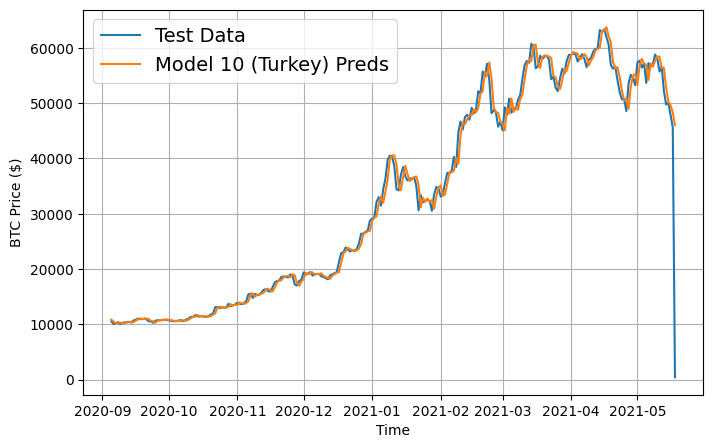

In [128]:
# Viewing Predictions
offset = 300
plt.figure(figsize=(8,5))
plot_timeseries(
    timesteps=btc_timesteps_turkey[-len(X_test_turkey):],
    values=prices_turkey[-len(y_test_turkey):],
    start=offset,
    format='-',
    label='Test Data',
    new_figure=False)

plot_timeseries(
    timesteps=btc_timesteps_turkey[-len(X_test_turkey):],
    values=model_10_preds,
    start=offset,
    format='-',
    label='Model 10 (Turkey) Preds',
    new_figure=False)

## Analysis

After running the 10 experiments, I want to analyze the performance and prediction metrics of each model to identify how well each model performed and analyze how certain data can affect predictions.

#### Prediction Metrics

Analyzing how each model performed and comparing the `MAE` of each model.

In [129]:
# All models
all_model_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_results,
    model_7_results,
    model_8_median_results,
    model_8_mean_results,
    model_10_results,
]

all_model_results

[RegressionPredictionMetrics(mae=567.9802273457542, mse=1147547.125023896, rmse=1071.2362601330744, mape=2.516524929982267, mase=0.9995699939182626, huber=567.4802, name='model_0_naive'),
 RegressionPredictionMetrics(mae=564.6194, mse=1156819.9, rmse=1075.5557, mape=2.5089412, mase=0.99187976, huber=564.1206, name='model_1_dense_w7_h1'),
 RegressionPredictionMetrics(mae=626.0105, mse=1289388.1, rmse=1135.5123, mape=2.9079008, mase=1.0942725, huber=625.51074, name='model_2_dense_w30_h1'),
 RegressionPredictionMetrics(mae=1236.0518, mse=5398413.5, rmse=1432.8201, mape=5.744262, mase=2.1941037, huber=1235.552, name='model_3_dense_w30_h7'),
 RegressionPredictionMetrics(mae=575.3289, mse=1195277.8, rmse=1093.2876, mape=2.5671804, mase=1.0106934, huber=574.82996, name='model_4_conv1d'),
 RegressionPredictionMetrics(mae=589.0396, mse=1243140.9, rmse=1114.9623, mape=2.6528945, mase=1.0347793, huber=588.5398, name='model_5_lstm'),
 RegressionPredictionMetrics(mae=566.3741, mse=1157861.8, rmse=1

In [130]:
# Dataframe
all_results_df = ml_toolbox.analysis.regression.generate_prediction_metrics_dataframe(all_model_results)
all_results_df

,mae,mse,rmse,mape,mase,huber
model_0_naive,567.980227,1.147547e+06,1071.236260,2.516525,0.999570,567.480225
model_1_dense_w7_h1,564.619385,1.156820e+06,1075.555664,2.508941,0.991880,564.120605
model_2_dense_w30_h1,626.010498,1.289388e+06,1135.512329,2.907901,1.094272,625.510742
model_3_dense_w30_h7,1236.051758,5.398414e+06,1432.820068,5.744262,2.194104,1235.552002
model_4_conv1d,575.328918,1.195278e+06,1093.287598,2.567180,1.010693,574.829956
model_5_lstm,589.039612,1.243141e+06,1114.962280,2.652894,1.034779,588.539795
model_6_dense_multivariate,566.374084,1.157862e+06,1076.039795,2.512168,0.994962,565.874084
model_7_n_beats,671.831726,1.500288e+06,1224.862549,3.107747,1.180222,671.331726
model_8_ensemble_median,565.281616,1.154940e+06,1074.681152,2.508564,0.993043,564.783203
model_8_ensemble_mean,566.547119,1.158042e+06,1076.123535,2.514830,0.995266,566.047546


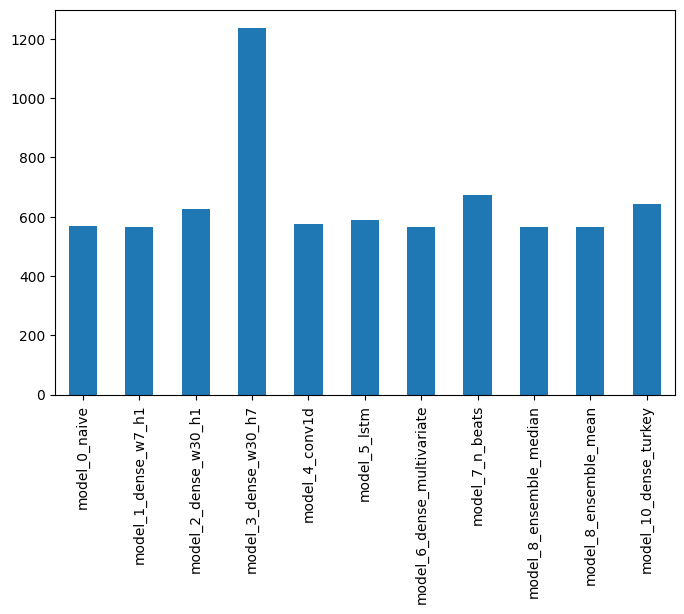

In [131]:
# Plot Results
all_results_df['mae'].plot(figsize=(8,5), kind='bar');

#### Performance Metrics

Analyzing the performance metrics associated with making predictions. This is used to compare how fast a predction can be made given each model.

In [141]:
# Performance Metrics
all_but_model_0_perfomance_metrics = [
    model_1_performance,
    model_2_performance,
    model_3_performance,
    model_4_performance,
    model_5_performance,
    model_6_performance,
    model_7_performance,
]

all_but_model_0_perfomance_metrics

[Performance(total_time=0.0950425000000017, total_predictions=556, name='model_1_dense_w7_h1'),
 Performance(total_time=0.08208841600000483, total_predictions=552, name='model_2_dense_w30_h1'),
 Performance(total_time=0.08061370899999787, total_predictions=551, name='model_3_dense_w30_h7'),
 Performance(total_time=0.13024129100000437, total_predictions=556, name='model_4_conv1d'),
 Performance(total_time=0.20399175000000014, total_predictions=556, name=None),
 Performance(total_time=0.07496470899999963, total_predictions=556, name='model_6_dense_multivariate'),
 Performance(total_time=0.900290874999996, total_predictions=1, name='model_7_n_beats')]

In [142]:
# Performance Metrics DF
all_but_model_0_performance_df = performance_toolbox.model.generate_performance_dataframe(all_but_model_0_perfomance_metrics)
all_but_model_0_performance_df

,total_time,total_predictions,time_per_prediction
model_1_dense_w7_h1,0.095043,556.0,0.000171
model_2_dense_w30_h1,0.082088,552.0,0.000149
model_3_dense_w30_h7,0.080614,551.0,0.000146
model_4_conv1d,0.130241,556.0,0.000234
experiment_4,0.203992,556.0,0.000367
model_6_dense_multivariate,0.074965,556.0,0.000135
model_7_n_beats,0.900291,1.0,0.900291


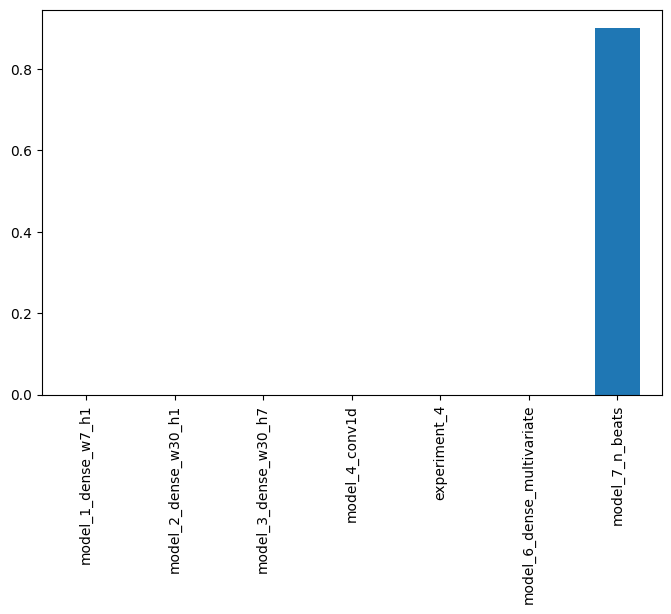

In [147]:
# Plotting Performance
all_but_model_0_performance_df['time_per_prediction'].plot(figsize=(8, 5), kind='bar');

#### Findings

After generating and exploring 10 models, the ultimate outcome is that predicting timeseries data just doesn't work. The N-BEATS model is significantly less performant than the other models with virtually no difference in the validation loss metrics.

In short, predicting timeseries data does not work.